# Predict Oslo Housing Prices

### Load libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

In [2]:
np.random.seed(5)

plt.style.use('fivethirtyeight')

### Load data

In [3]:
data_load = pd.read_csv("files/housing_listings_2021-04-28.csv")

data_load.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   new_building           1549 non-null   bool   
 1   location               1381 non-null   object 
 2   address                1549 non-null   object 
 3   price                  1549 non-null   int64  
 4   title                  1549 non-null   object 
 5   facilities             1467 non-null   object 
 6   description_text       1549 non-null   object 
 7   date_changed           1548 non-null   object 
 8   ad_url                 1549 non-null   object 
 9   id                     1549 non-null   int64  
 10  fellesgjeld            1079 non-null   float64
 11  omkostninger           1548 non-null   float64
 12  totalpris              1549 non-null   int64  
 13  felleskost_mnd         1455 non-null   float64
 14  boligtype              1549 non-null   object 
 15  eief

### Remove columns with more than 15% missing

In [4]:
cols_missing = data_load.isna().mean()
cols_to_remove = cols_missing[cols_missing > 0.15]

data = data_load.drop(cols_to_remove.keys(), axis=1)

### Remove rows with too many missing

In [5]:
rows_missing = data.apply(lambda x: x.count(), axis=1)
rows_to_remove = rows_missing[rows_missing < 22]

data = data.drop(rows_to_remove.keys(), axis=0)

### Define features

In [6]:
data_num = data.select_dtypes(include=['int64','float64'])

X = data_num.drop(['id','omkostninger','price','totalpris','bruttoareal','bruksareal','formuesverdi'], axis=1)
y = data_num['totalpris']

feature_names = X.columns

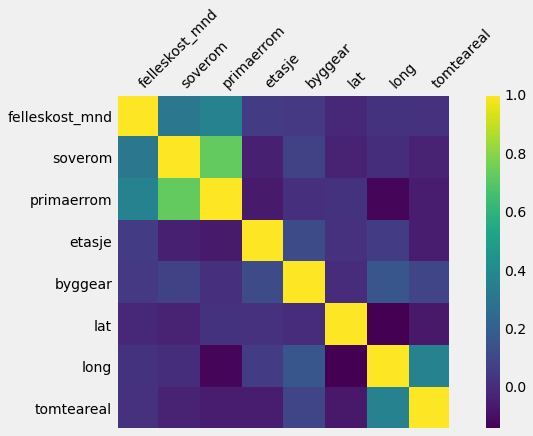

In [7]:
features_corr = X.corr()
plt.figure(figsize=(12,6))
plt.matshow(features_corr, fignum=1)
plt.xticks(range(len(feature_names)), feature_names, rotation=45, ha='left')
plt.yticks(range(len(feature_names)), feature_names)
plt.colorbar()
plt.grid(False)
plt.show()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X * 1.0, y, test_size=0.2)

### Define pipeline

In [9]:
def get_pipeline(model):
    steps = [('imputation', SimpleImputer(missing_values=np.nan, strategy='median')),
             ('scaler', StandardScaler()),
             ('model', model)]
         
    return(Pipeline(steps))

### Define models and evaluation process

In [10]:
models_dict = {
    "Linear Regression (Ridge)": get_pipeline(Ridge()),
    "Linear Regression (Lasso)": get_pipeline(Lasso()),
    "Decision Tree": get_pipeline(DecisionTreeRegressor()),
    "Neural Network": get_pipeline(MLPRegressor(max_iter=500)),
    "Random Forest": get_pipeline(RandomForestRegressor()),
    "Elastic Net": get_pipeline(ElasticNet()),
    "Gradient Boosting": get_pipeline(GradientBoostingRegressor()),
}

In [11]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
        
    # Fit model
    model.fit(X_train, y_train)
        
    # Make predictions
    y_pred = model.predict(X_test)
        
    # Calculate RMSE
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
        
    # Calculate R^2
    r2 = model.score(X_test, y_test)
        
    # Return average RMSE and R^2
    return rmse, r2

### Run through models in loop

In [12]:
for name, model in models_dict.items():
    rmse, _ = evaluate_model(model, X_train, y_train, X_test, y_test)
    print(name + " RMSE: {:0,.0f} NOK".format(int(rmse)))

Linear Regression (Ridge) RMSE: 3,598,145 NOK
Linear Regression (Lasso) RMSE: 3,595,722 NOK
Decision Tree RMSE: 4,330,089 NOK


/Users/dtroelfs/Applications/anaconda3/envs/mmiv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network RMSE: 10,020,247 NOK
Random Forest RMSE: 3,796,126 NOK
Elastic Net RMSE: 4,524,360 NOK
Gradient Boosting RMSE: 3,748,510 NOK


In [13]:
for name, model in models_dict.items():
    _, r2 = evaluate_model(model, X_train, y_train, X_test, y_test)
    print(name + " R Squared: {:.3f}".format(r2))

Linear Regression (Ridge) R Squared: 0.755
Linear Regression (Lasso) R Squared: 0.755
Decision Tree R Squared: 0.647


/Users/dtroelfs/Applications/anaconda3/envs/mmiv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network R Squared: -0.903
Random Forest R Squared: 0.733
Elastic Net R Squared: 0.612
Gradient Boosting R Squared: 0.739


### Re-run on best performing base model

In [14]:
model = get_pipeline(GradientBoostingRegressor())

In [15]:
params_grid = {'model__criterion': ['friedman_mse','mse','mea'],
               'model__alpha': np.linspace(0.5, 0.99, num=10),
               'model__learning_rate': np.linspace(0.08,0.4, num=10),
               'model__n_estimators' : np.linspace(50,500, num=20, dtype='int'),
               'model__max_depth': np.linspace(1, 10, dtype='int')}

model = RandomizedSearchCV(model, params_grid, n_iter=50, n_jobs=-1)

In [16]:
model.fit(X_train, y_train)

/Users/dtroelfs/Applications/anaconda3/envs/mmiv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.7491856  0.62926126 0.69295905 0.72437188 0.65792677 0.71883387
 0.73665684 0.77603005 0.76563879 0.74705777 0.71172973 0.75735148
 0.69153766 0.72346843 0.74323964 0.78142834        nan 0.61520692
        nan 0.7662384         nan        nan        nan        nan
        nan        nan 0.6987299  0.71102523 0.74874257 0.68371506
 0.78910389        nan 0.75134526        nan        nan 0.71343379
 0.75242118 0.68358575        nan 0.67249481        nan        nan
        nan 0.62271102        nan 0.72028006 0.77962397 0.60846076
 0.77302391 0.73840439]
  warnings.warn(


RandomizedSearchCV(estimator=Pipeline(steps=[('imputation',
                                              SimpleImputer(strategy='median')),
                                             ('scaler', StandardScaler()),
                                             ('model',
                                              GradientBoostingRegressor())]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'model__alpha': array([0.5       , 0.55444444, 0.60888889, 0.66333333, 0.71777778,
       0.77222222, 0.82666667, 0.88111111, 0.93555556, 0.99      ]),
                                        'model__criterion': ['friedm...
                                        'model__learning_rate': array([0.08      , 0.11555556, 0.15111111, 0.18666667, 0.22222222,
       0.25777778, 0.29333333, 0.32888889, 0.36444444, 0.4       ]),
                                        'model__max_depth': array([ 1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,
        4, 

### Evaluate model

In [17]:
r2 = model.score(X_test, y_test)
print("Best parameters: {}".format(model.best_params_))
print("R squared: {}".format(np.round(r2,3)))

Best parameters: {'model__n_estimators': 50, 'model__max_depth': 3, 'model__learning_rate': 0.11555555555555555, 'model__criterion': 'mse', 'model__alpha': 0.5544444444444444}
R squared: 0.735


In [18]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("RMSE: {:0,.0f} NOK".format(int(np.sqrt(mse))))

RMSE: 3,742,024 NOK


### Plot Feature Importance

In [19]:
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10)
feature_importances = perm_importance.importances_mean

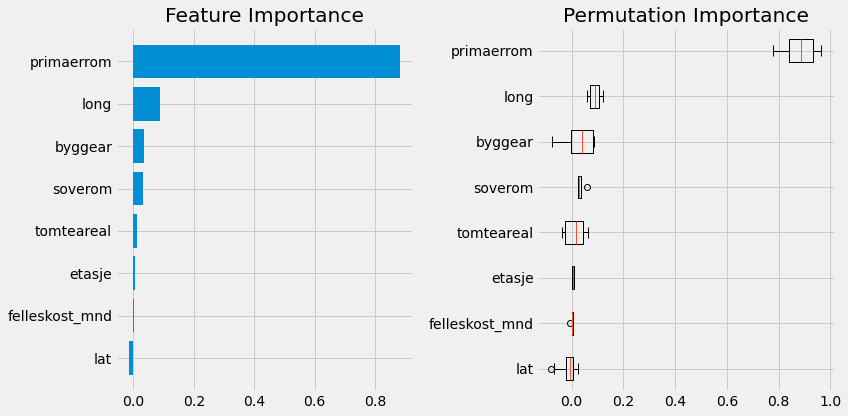

In [20]:
sorted_idx = np.argsort(feature_importances)
pos = np.arange(sorted_idx.shape[0])
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importances[sorted_idx], align='center')
plt.yticks(pos, feature_names[sorted_idx])
plt.title('Feature Importance')

plt.subplot(1, 2, 2)
plt.boxplot(perm_importance.importances[sorted_idx].T,
            vert=False, labels=feature_names[sorted_idx])
plt.title("Permutation Importance")

fig.tight_layout()
plt.show()